# Figure 6: multi year energy droughts
With this jupyter notebook you can generates Figure 6 of:  van der Most et al. Temporally compounding energy droughts in European electricity systems with hydropower

In [ ]:
# general packages 
import sys

import pandas as pd
import xarray as xr
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.collections import PolyCollection
from matplotlib.colors import to_rgb
from matplotlib.legend_handler import HandlerTuple
import matplotlib.image as image
import string
import matplotlib as mpl

# Set the font to sans-serif, preferring Helvetica or Arial
mpl.rcParams['font.sans-serif'] = ["Helvetica", "Arial", "sans-serif"]

# Set the default font type to sans-serif
mpl.rcParams['font.family'] = 'sans-serif'

# Set the maximum font size to 7pt
mpl.rcParams['font.size'] = 5
mpl.rcParams['legend.fontsize'] = 5

# Set the minimum font size for smaller text elements, like tick labels
mpl.rcParams['xtick.labelsize'] = 5
mpl.rcParams['ytick.labelsize'] = 5

# set figure linewidths
mpl.rcParams['axes.linewidth'] = 0.5
mpl.rcParams['grid.linewidth'] = 0.5
mpl.rcParams['xtick.major.width'] = 0.6
mpl.rcParams['ytick.major.width'] = 0.6
mpl.rcParams['xtick.minor.width'] = 0.4
mpl.rcParams['ytick.minor.width'] = 0.4

In [ ]:
def create_fanchart(df, ax, name, color):
   
    mean = df.mean(axis=1)
    offsets = (0, 0.1, 0.25)
    ax.plot(mean, color=color, lw=2, label= f'mean of {name} (n={len(df.columns)})')
    
    for offset in offsets:

        low = df.quantile(0+offset, axis=1)
        high = df.quantile(1-offset, axis=1)
        # since `offset` will never be bigger than 50, do 55-offset so that
        # even for the whole range of the graph the fanchart is visible
        alpha = (0.2+offset)
        l =  f'p{int(100*offset)}-p{int((1-offset)*100)} of {name}' if offset !=0 else f'all of {name}'
        
        ax.fill_between(df.index, low, high, color=color, alpha=alpha, label =l)
               

In [2]:
# load data          
folder = 'data_for_images/'
var0='residual'

# a) flowscheme image load 
file =folder+'flowscheme.png'
flowscheme =image.imread(file)

# b) events and normalized anomalies
eventfile = folder + 'residual_q0.97_all_v4.csv'
datecols=['time']
# open normalized anoms
anoms = xr.open_dataset(folder+'fig6_SWE_residual_LENTIS_PD_02_v4_anoms.nc')

# c) load violin plot data
df_violin = pd.read_csv(folder + 'fig6_violinplotdata.csv', index_col=0)
# remove switzerland
df_violin = df_violin.loc[df_violin.country!='CHE']


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial, sans-serif


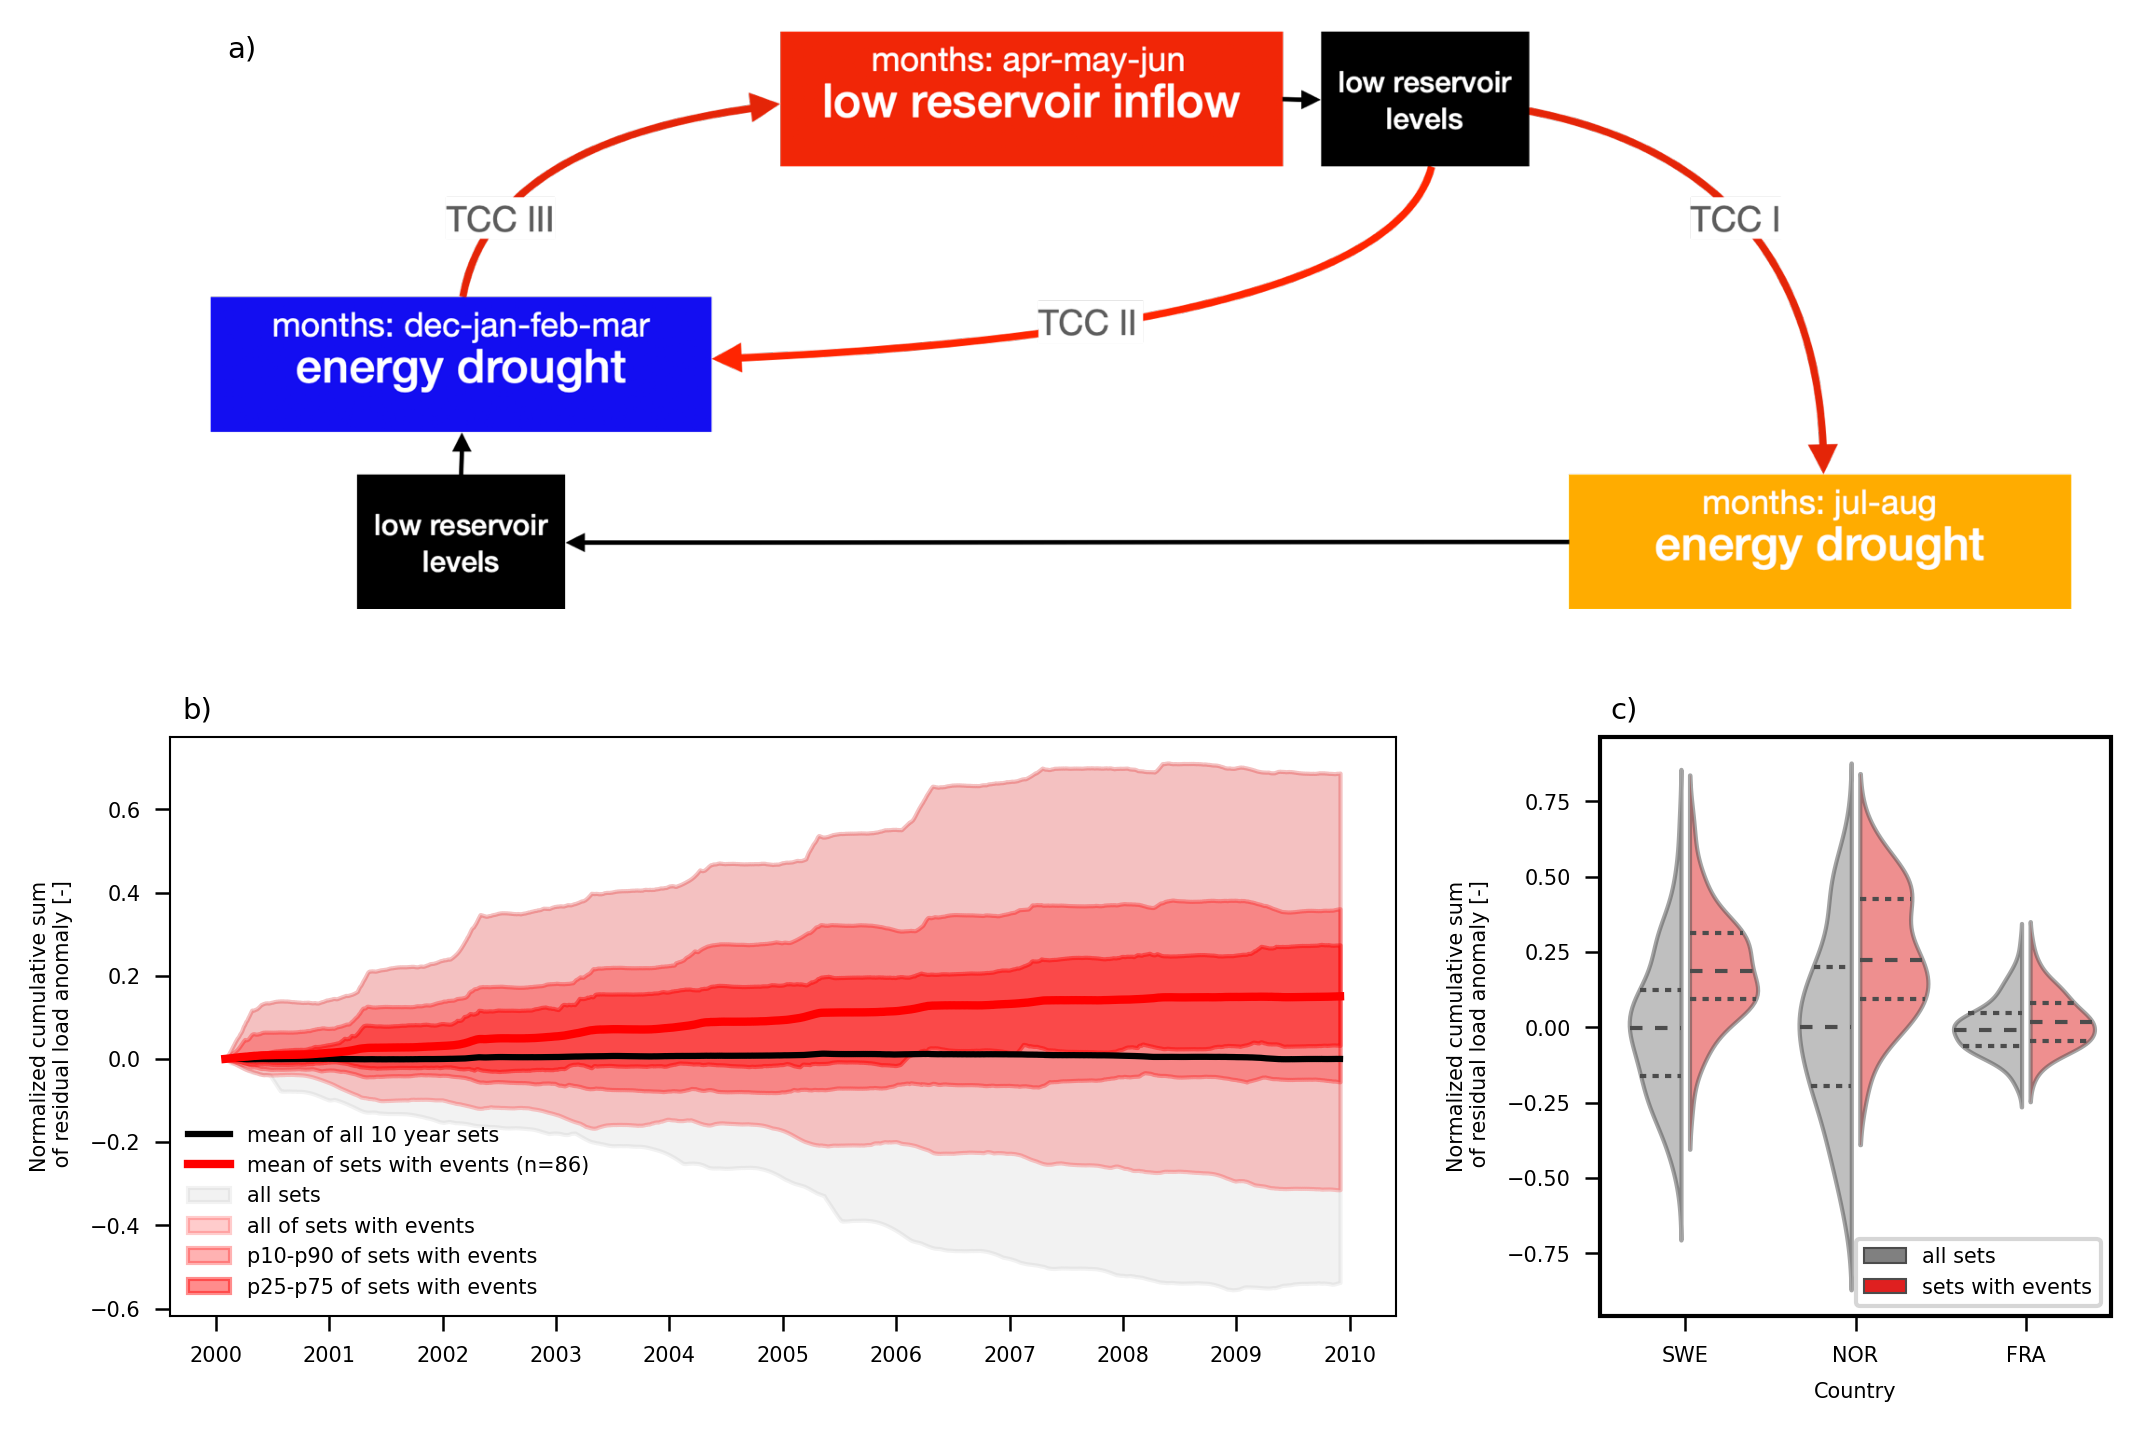

In [10]:
# Define your size in millimeters
width_mm = 180

# Convert to inches
width_in = width_mm / 25.4

# fig = plt.figure(figsize=(10, 9.5), dpi=75)#,constrained_layout=True)  # Adjust the figure size
fig, axes = plt.subplot_mosaic('AAA;BBC', figsize=(width_in, 2/3*width_in), dpi=300)
# fontsize


#subplots
ax0 = axes['A']#fig.add_subplot(2, 1, 1)#, adjustable='box', aspect=0.3)  # first
ax1 = axes['B']#fig.add_subplot(2, 2, 3)#, adjustable='box', aspect=0.3)  # first
ax2 = axes['C']#fig.add_subplot(2, 2, 4)#, adjustable='box', aspect=0.3)  # first

color_cycler = ['c', 'm', 'y', 'k','r', 'b']

country = 'SWE'

i=0

# open country events
events = pd.read_csv(eventfile, index_col=0)
events = events.loc[events.country==country]
events = events.groupby('event_nr').first()
events=events[0:160]

# make dataset with only runs in which events take place
dsevents = anoms.sel(runs=events.runs.unique())

dflast = anoms[var0].cumsum(dim='time').isel(time=-1).to_dataframe()
dflaste = dsevents[var0].cumsum(dim='time').isel(time=-1).to_dataframe()

ax = axes['B']
# df.plot(legend=False, color='grey', alpha=0.2)
# df.mean(axis=1).plot(legend=False, color='black')
df = anoms[var0].cumsum(dim='time').to_dataframe().reset_index()
df = df.pivot(index='time', values=var0, columns='runs')
ax.fill_between(df.index, df.max(axis=1), df.min(axis=1), color='grey', alpha=0.1,label = 'all sets', zorder=0)
ax.plot(df.index, df.mean(axis=1), color='black', label = 'mean of all 10 year sets', zorder=1)


df = dsevents[var0].cumsum(dim='time').to_dataframe().reset_index()
df = df.pivot(index='time', values=var0, columns='runs')
create_fanchart(df, ax, f'sets with events', 'red')

dseventscumsum = dsevents.cumsum('time')
dseventscumsum['time'] = dsevents.time
# dsevents = dsevents.cumsum(dim='time')
# open country events
events = pd.read_csv(eventfile, index_col=0, parse_dates=datecols)
events = events.loc[events.country==country]
events = events.groupby('event_nr').first()
events=events[0:160]

## plot individual events
eventlist = []
onevent_runs = events.groupby('runs').count()
onevent_runs = onevent_runs.loc[onevent_runs.residual==1]

axes['B'].set_ylabel(f'Normalized cumulative sum\n of {var0} load anomaly [-]')
axes['B'].legend(loc='lower left', frameon=False)

axes['A'].imshow(flowscheme)
axes['A'].axis('off')

ax = sns.violinplot(data=df_violin, x="country", y=var0, hue="subset", 
                    split=True, inner='quart', ax=ax2, linewidth=1,
                    palette={"all sets": "grey", "sets with events": "red"})
sns.despine(left=True, ax=ax)
delta = 0.025
for ii, item in enumerate(ax.collections):
    if isinstance(item, PolyCollection):
        path, = item.get_paths()
        vertices = path.vertices
        if ii % 2:  # -> to right
            vertices[:, 0] += delta
        else:  # -> to left
            vertices[:, 0] -= delta
for i, line in enumerate(ax.get_lines()):
    line.get_path().vertices[:, 0] += delta if i // 3 % 2 else -delta

colors = sns.color_palette('Set2')
colors = ['#ff0000', '#FFB14E','#E8246F']
ax.legend(loc='lower right').set_title('')
axes['C'].set_ylabel(f'Normalized cumulative sum\n of {var0} load anomaly [-]')
axes['C'].set_xlabel('Country')

# sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.setp(ax.collections, alpha=.5)
# add border to violin plot
axes['C'].patch.set_edgecolor('black')  
axes['C'].patch.set_linewidth('1')  

# ad text string
for n, (ax, location) in enumerate(zip([ax0, ax1, ax2], [(0.01, 0.99), (0.01, 1.07), (0.02, 1.07)])):
    ax.text(location[0], location[1], string.ascii_lowercase[n] + ')', ha='left', va='top',transform=ax.transAxes,
               size=7)

plt.tight_layout()
fig.subplots_adjust(hspace=0.22, wspace=0.4)
